# Customer Service Data Clustering
這個檔案是想要將 Customer Service 的資料作 unsupervised clustering。為了要做分群，首先我實驗用 TFIDF、Doc2vec、Bert 來建 sentence representation，接著再實驗使用 DBSCAN、Kmeans 來做分群。

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

import pickle

from tqdm import tqdm

from sklearn.cluster import DBSCAN

### Configuration

In [2]:
path = os.path.join("..","data","./newdata_clean.xlsx")
n_cpu = 16
batch_size = 10000
max_k = 30
max_features = 256  # only consider the top max_features ordered by term frequency across the corpus.
loadpath = "processed_data_lda_wo_html"
#loadpath = "processed_data_not_rmsw"

In [3]:
with open(loadpath, "rb") as f:
    output = pickle.load(f)
clean_data = output["clean_data"]
reduced_data = output["reduced_data"]
token_data = output["token_data"]

`find_optimal_clusters()` 會實驗 kmeans 分群分別分成 2 到 max_k 個群中，每個群的 SSE，最後會畫出一張分成不同個數的群的 SSE 值。根據這個圖我們可以選出最適合的分群數量。（SSE 代表的是每個點距離 kmeans 中心點的 distance。）

事實上分的群越多，所算出來的 SSE 一定會越低，所以正確得選擇分群個數的方法是選擇 SSE 曲線突然大幅驟降的位置。

In [4]:
def find_optimal_clusters(data, max_k, batch_size):
    iters = range(2, max_k+1, 2)
    
    sse = []
    bar = tqdm(iters)
    for k in bar:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=20).fit(data).inertia_)
        bar.set_description('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

`cluster_and_plot()`  function 會依照參數選擇分群的演算法，然後分群完後再使用 PCA 或是 TSNE 的降維演算法來降到二維平面上方便視覺化。這邊也實驗了多種的降維組合，包括單獨 PCA、先 PCA 降一半維度再用 TSNE、TSNE 搭配不同的 perplexity、iteration。

In [5]:
def cluster_and_plot(data, cluster_algo, n_clusters, eps, calculate_portion, draw_portion):
    n_data = data.shape[0]
    print("Input Data shape:", data.shape)
    
    # random sample (n_sample) points
    np.random.seed(5)
    n_sample = n_data // calculate_portion
    print("Only calculate {} data points".format(n_sample))
    sample_items = np.random.choice(range(n_data), size=n_sample, replace=False)
    
    
    if cluster_algo == "kmeans":
        labels = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=20).fit_predict(data)
        npdata = data[sample_items,:]
        label_subset = labels[sample_items]
    elif cluster_algo == "dbscan":
        npdata = data[sample_items]
        labels = DBSCAN(eps=eps, n_jobs=n_cpu).fit_predict(npdata)
        label_subset = labels
        print("Number of noise data: {}".format(len(label_subset[label_subset == -1])))
    
    print(npdata.shape)
    # number of clusters
    max_label = max(labels) 
    print("Number of clusters: {}".format(max_label + 1))
    pca = PCA(n_components=2, whiten=True).fit_transform(npdata)
    print("PCA done")
    tsne_pca = TSNE(n_jobs=n_cpu, n_iter=1000).fit_transform(PCA(n_components=(max_features // 2)).fit_transform(npdata))
    print("tsne_pca done")
    tsne = TSNE(n_jobs=n_cpu, n_iter=1000).fit_transform(npdata)
    print("tsne30 done")
    tsne_per50 = TSNE(n_jobs=n_cpu, perplexity=50, n_iter=1000).fit_transform(npdata)
    print("tsne50 done")
    
    # draw only (n_draw) points
    np.random.seed(5)
    n_draw = n_sample // draw_portion
    print("Only draw {} data points".format(n_draw))
    idx = np.random.choice(range(pca.shape[0]), size=n_draw, replace=False)
    
    # draw scatter
    if cluster_algo == "kmeans":
        start_idx = 0
    else:
        start_idx = -1
    f, ax = plt.subplots(2, 2, figsize=(13, 10))
    for i in range(start_idx,max_label + 1):
        sub_idx = idx[label_subset[idx] == i]
        #print("{} points in group {}".format(len(sub_idx),i))
        label_subset_color = np.array([cm.hsv(i/ ( max_label + 1)) for i in label_subset[sub_idx]])
        ax[0,0].scatter(pca[sub_idx, 0], pca[sub_idx, 1])   # , c=label_subset_color
        ax[0,0].set_title('PCA Cluster Plot')
        
        ax[1,0].set_title('t-SNE & PCA Cluster Plot')
        ax[1,0].scatter(tsne_pca[sub_idx, 0], tsne_pca[sub_idx, 1], label="Group {} | {}".format(i,len(sub_idx))) # , c=label_subset_color
        
        ax[0,1].set_title('t-SNE Cluster Plot')
        ax[0,1].scatter(tsne[sub_idx, 0], tsne[sub_idx, 1]) # , c=label_subset_color
        
        ax[1,1].set_title('t-SNE Cluster Plot (Perplexity 50)')
        ax[1,1].scatter(tsne_per50[sub_idx, 0], tsne_per50[sub_idx, 1]) # , c=label_subset_color
    f.legend() # plot only one legend
    
    if cluster_algo == "kmeans":
        return data, labels
    else:
        return npdata, labels

## TF-IDF Clustering

In [6]:
print("max_feature",max_features)
tfidf = TfidfVectorizer(
    min_df = 0.001,
    max_df = 0.95,
    max_features = max_features,
    stop_words = 'english'
)
tfidf.fit(clean_data)
text = tfidf.transform(clean_data).todense()

max_feature 256


Fit 30 clusters: 100%|██████████| 15/15 [00:46<00:00,  3.82s/it]


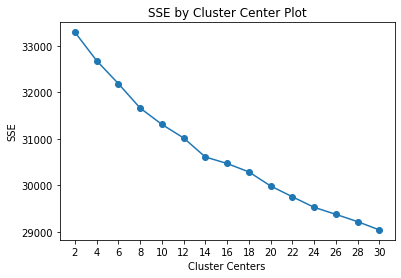

In [7]:
find_optimal_clusters(text, max_k, batch_size)

### Clustering by Kmeans

Input Data shape: (36939, 256)
Only calculate 1846 data points
(1846, 256)
Number of clusters: 10
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 1846 data points


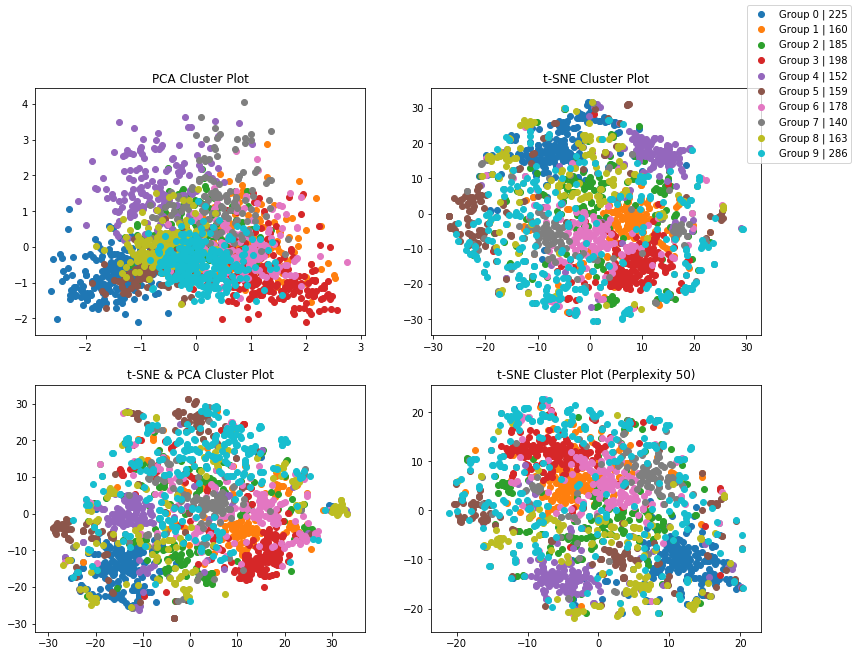

In [8]:
sample_text, sample_text_labels = cluster_and_plot(text, "kmeans", 10, None, 20, 1)

### Clustering by DBSCAN

Input Data shape: (36939, 256)
Only calculate 1846 data points
Number of noise data: 660
(1846, 256)
Number of clusters: 10
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 1846 data points


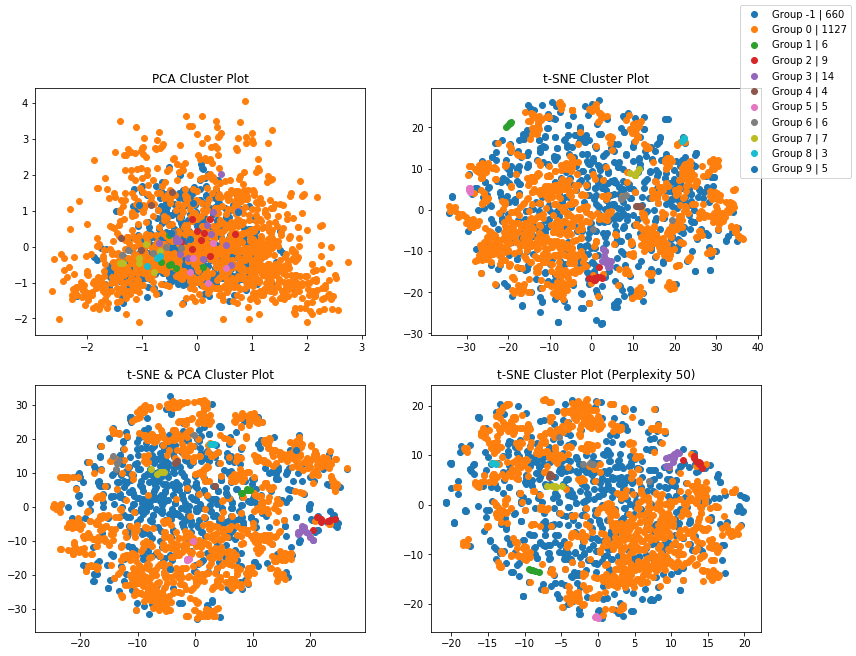

In [9]:
_ = cluster_and_plot(text, "dbscan", None, 1.04, 20, 1)

### Get keywords of each TF-IDF cluster
作法是將每個 cluster 的前幾高 tfidf 字取出來，作為這個 cluster 的代表字。但是效果不好，且很多 cluster 都有相同常見的字(ex: download)

In [ ]:
def get_top_keywords(data, text, clusters, labels, n_terms):
    data = np.array(data)
    clusters = np.array(clusters)
    text_feature = text
    labels = np.array(labels)
    group = pd.DataFrame(text).groupby(clusters)
    #print("Data point in each group:\n", group.size())
    df = group.mean() # [(clusters) rows x (feature) columns]

    for i,r in df.iterrows():
        sub_text = data[clusters == i]
        sub_text_list = sub_text
        sub_text_feature = text_feature[clusters == i]
        #print("sub_text: {} | sub_text_feature: {}".format(sub_text.shape,sub_text_feature.shape))

        dist = np.linalg.norm(sub_text_feature - np.array(r), axis=1)

        #print("Euclidean distance:", dist.shape, dist)
        
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        #print(','.join([str(r[t]) for t in np.argsort(r)[-n_terms:]]))
        print('\n'.join([re.sub(' +', ' ',sub_text_list[t]) + " | " + str(dist[t]) for t in np.argsort(dist)[-2:]]))
            
get_top_keywords(reduced_data, sample_text, sample_text_labels, tfidf.get_feature_names(), 10)

## Doc2vec Clustering
因為自己 train 一個 doc2vec model 實在曠日廢時，因此我這邊使用了 [English Wikipedia DBOW (1.4GB)](https://ibm.ent.box.com/s/3f160t4xpuya9an935k84ig465gvymm2) 的 pretrain model。

ref: https://github.com/jhlau/doc2vec

In [14]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
tagged_data = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(token_data)]

max_epochs = 100
alpha = 0.025

model = Doc2Vec(vector_size=max_features,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                workers=n_cpu,
                dm=1)
  
model.build_vocab(tagged_data)
bar = tqdm(range(max_epochs))
for epoch in bar:
    bar.set_description('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [15]:
model= Doc2Vec.load("enwiki_dbow/doc2vec.bin")
'''
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)


# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])
'''

n_reduced_data = len(reduced_data)
docvec = []
for i in tqdm(range(n_reduced_data)):
    #docvec.append(model.docvecs[str(i)])
    docvec.append(model.infer_vector(token_data[i]))
docvec = np.array(docvec)
print("Number of data: {}".format(n_reduced_data))

100%|██████████| 36939/36939 [00:48<00:00, 765.94it/s]

Number of data: 36939


Fit 30 clusters: 100%|██████████| 15/15 [00:56<00:00,  5.23s/it]


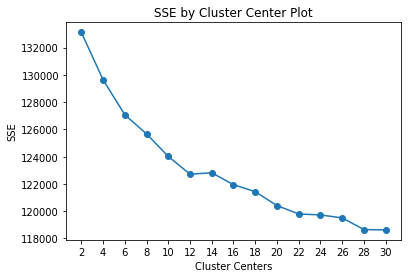

In [16]:
find_optimal_clusters(docvec, max_k, batch_size)

### Clustering by Kmeans

Input Data shape: (36939, 300)
Only calculate 1846 data points
(1846, 300)
Number of clusters: 10
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 1846 data points


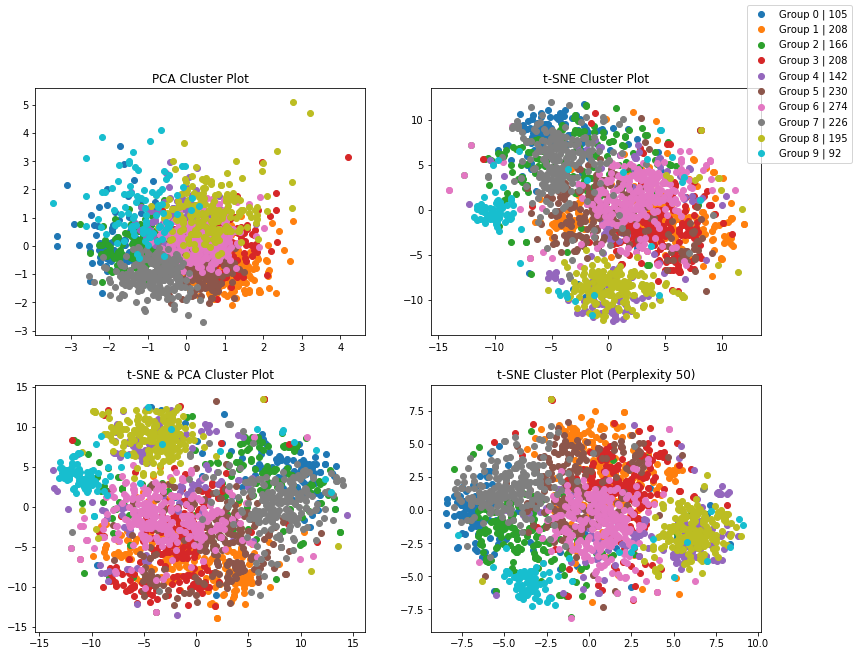

In [17]:
_ = cluster_and_plot(docvec, "kmeans", 10, None, 20, 1)

### Clustering by DBSCAN

Input Data shape: (36939, 300)
Only calculate 1846 data points
Number of noise data: 1488
(1846, 300)
Number of clusters: 2
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 1846 data points


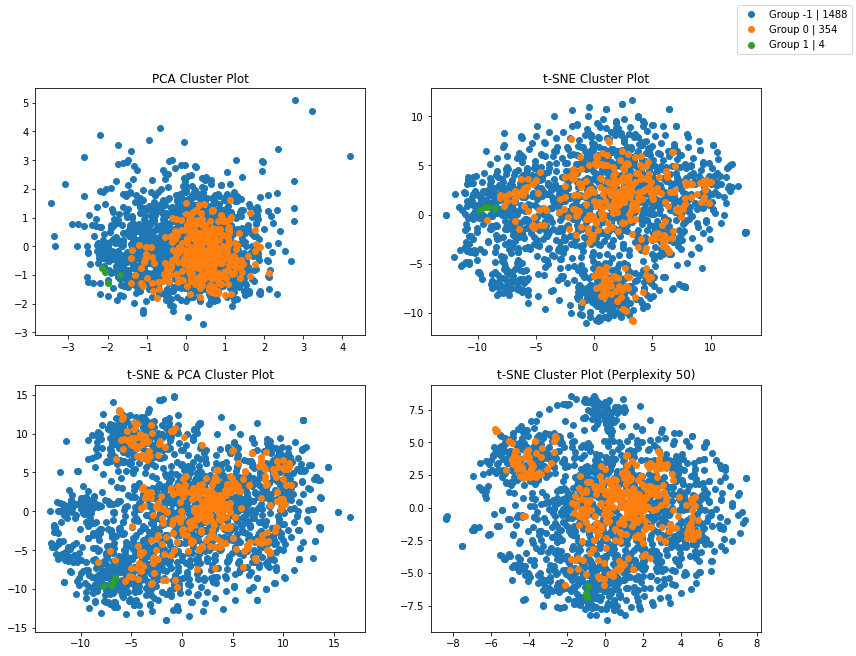

In [18]:
_ = cluster_and_plot(docvec, "dbscan", None, 1.6, 20, 1)

### Reference
* [Clustering documents with TFIDF and KMeans](https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans)
* [Analyzing tf-idf results in scikit-learn](https://buhrmann.github.io/tfidf-analysis.html)

## Bert Sentence Encoding Clustering

1. 要先把 bert server 開起來
    `gpu0 bert-serving-start -model_dir uncased_L-12_H-768_A-12 -num_worker 4  -port 1355 -max_seq_len 40 -device_map 0`
2. 直到出現 `all set, ready to serve request!` 才可以 run client 的 command
Note:
1. 如果是 run 大的 model 會 load 不進去 GPU 中，跑出 OOM
2. 如果系統記憶體不夠則不會出現 all set, ready to serve request!，CPU 版來說，最多只能 -num_worker 2

In [ ]:
from bert_serving.client import BertClient
bc = BertClient(port=1355)
print("Start predicting")
bert_output = bc.encode(clean_data)
bert_output[:10]

In [19]:
bert_data_path = "bert_base.pkl"

In [ ]:
bert_data = {
    "clean_data": clean_data,
    "reduced_data": reduced_data,
    "token_data": token_data,
    "bert_data": bert_output
}
with open(bert_data_path, "wb") as f:
    pickle.dump(bert_data, f)

In [20]:
with open(bert_data_path, "rb") as f:
    bert_data = pickle.load(f)
clean_data = bert_data["clean_data"]
reduced_data = bert_data["reduced_data"]
token_data = bert_data["token_data"]
bert_output = bert_data["bert_data"]

Fit 30 clusters: 100%|██████████| 15/15 [02:19<00:00, 12.82s/it]


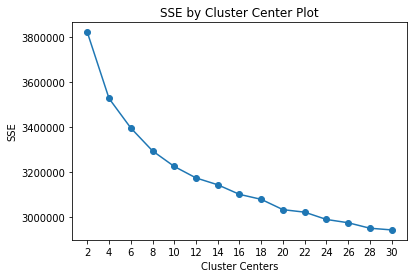

In [21]:
find_optimal_clusters(bert_output, max_k, batch_size)

### Clustering by Kmeans

Input Data shape: (102591, 768)
Only calculate 2051 data points
(2051, 768)
Number of clusters: 10
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 205 data points


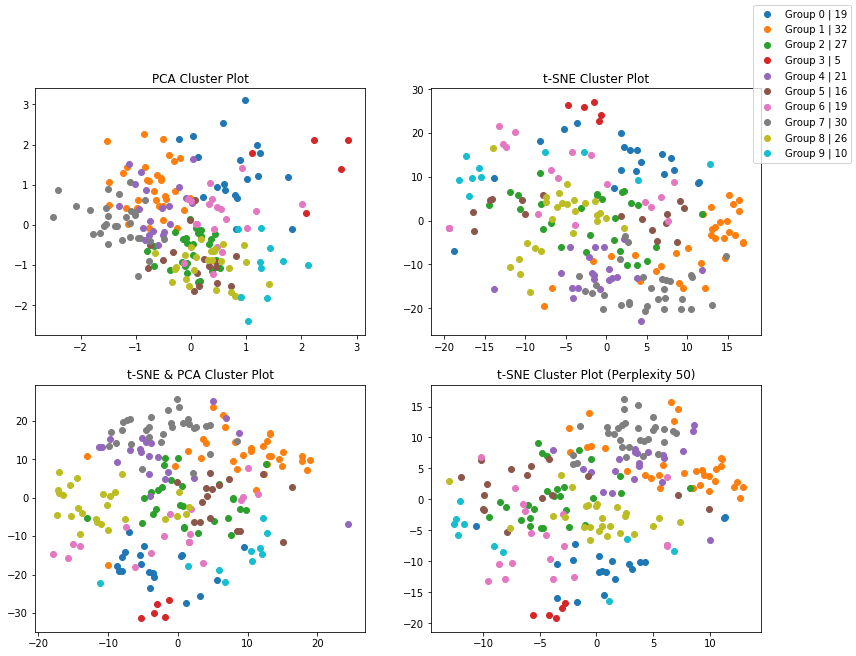

In [22]:
_ = cluster_and_plot(bert_output, "kmeans", 10, None, 50, 10)

### Clustering by DBSCAN

Input Data shape: (102591, 768)
Only calculate 2051 data points
Number of noise data: 768
(2051, 768)
Number of clusters: 3
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 205 data points


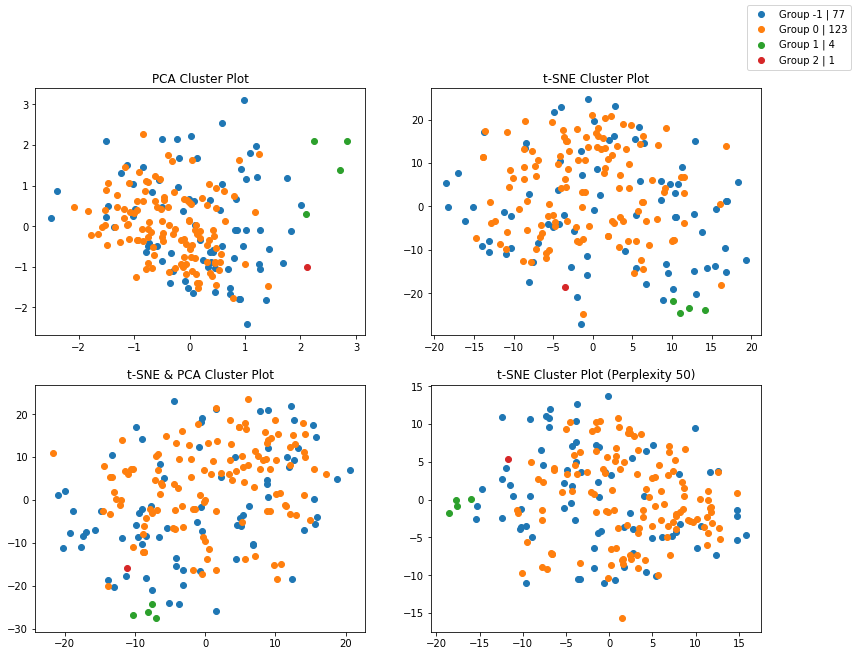

In [23]:
_ = cluster_and_plot(bert_output, "dbscan", None, 5.95, 50, 10)

## Conclusion
從做出來的結果可以發現 DBSCAN 並不適合做在這個 dataset上，僅管調過參數，可是他分得群還是夠少，而且 noise 過多。相比之下 kmeans 的結果就好很多，只是不同群的距離並沒有到很大而已。

此外我認為從分群的結果來看，Doc2vec 的 sentence representation 比 TFIDF 要來得好。